In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans

from tqdm.notebook import tqdm 

from torch.utils.tensorboard import SummaryWriter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler

from models.enhanced_baseline import EnhancedBaseLineModel
from ddpm.ddpm import GaussianDiffusion1D
from evaluation.evaluation import vizual_comparison, plot_jsd_per_customer, plot_kde_samples, make_gif_from_images, mmd_histogram_per_customer

# Params

In [ ]:
## Data
seq_len = 12
batch_size = 128
k = 15

#NN
device = 'cuda' if torch.cuda.is_available() else 'cpu'
latent_dim = 1000
cond_model = "mlp"
num_layers = 6
n_heads = 8
lr = 5e-5
decay_rate = 0.9
epochs = 2000
save_rate = 50

## DDPM
timesteps = 1000
beta_schedule = "cosine"
objective = "pred_noise"

## Logging
experiment = "rq1_12"
experiment_name = f"enhanced_baseline_{epochs//1000}kepochs_{seq_len}seq"
logging_dir = f"logging/{experiment}/{experiment_name}/"

In [3]:
if not os.path.isdir(logging_dir):
    os.makedirs(logging_dir)
    os.makedirs(os.path.join(logging_dir, "viz/"))
    os.makedirs(os.path.join(logging_dir, "jsd/"))
    os.makedirs(os.path.join(logging_dir, "kde/"))
    os.makedirs(os.path.join(logging_dir, "tensorboard/"))
    os.makedirs(os.path.join(logging_dir, "weights/"))
    os.makedirs(os.path.join(logging_dir, "ts_sample/"))
    os.makedirs(os.path.join(logging_dir, "mmd/"))

# Utils

In [4]:
PREPROCESSED_DIR = "./preprocessing/data/customer_led_network_revolution/preprocessed/"

In [5]:
class MakeDATA(Dataset):
    def __init__(self, data, seq_len):
        data = np.asarray(data, dtype=np.float32)
        seq_data = []
        for i in range(len(data) - seq_len + 1):
            x = data[i : i + seq_len]
            seq_data.append(x)
        self.samples = np.asarray(seq_data, dtype=np.float32) 

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [6]:
def cluster(data, k):
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(data.T)
    
    clustered_data = []
    for cluster in range(kmeans.n_clusters):
        cluster_data = data.iloc[:, cluster_labels == cluster].mean(axis=1)
        clustered_data.append(cluster_data)
        
    return pd.DataFrame(clustered_data).T

# Load Data

In [7]:
train = pd.read_csv(os.path.join(PREPROCESSED_DIR, "train.csv"))
val = pd.read_csv(os.path.join(PREPROCESSED_DIR, "val.csv"))
test = pd.read_csv(os.path.join(PREPROCESSED_DIR, "test.csv"))
cond_train = pd.read_csv(os.path.join(PREPROCESSED_DIR, "cond_train.csv"))
cond_val = pd.read_csv(os.path.join(PREPROCESSED_DIR, "cond_val.csv"))
cond_test = pd.read_csv(os.path.join(PREPROCESSED_DIR, "cond_test.csv"))

In [8]:
train.drop("Date and Time of capture", axis=1, inplace=True)
val.drop("Date and Time of capture", axis=1, inplace=True)
test.drop("Date and Time of capture", axis=1, inplace=True)

In [9]:
train = cluster(train, k)
test = cluster(test, k)
val = cluster(val, k)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [10]:
train.shape, val.shape, test.shape, cond_train.shape, cond_val.shape, cond_test.shape

((33984, 15), (6796, 15), (1700, 15), (33984, 27), (6796, 27), (1700, 27))

In [11]:
train_seq = np.asarray(MakeDATA(train, seq_len)).transpose(0, 2, 1)
cond_train_seq = np.asarray(MakeDATA(cond_train, seq_len)).transpose(0, 2, 1)

val_seq = np.asarray(MakeDATA(val, seq_len)).transpose(0, 2, 1)
cond_val_seq = np.asarray(MakeDATA(cond_val, seq_len)).transpose(0, 2, 1)

test_seq = np.asarray(MakeDATA(test, seq_len)).transpose(0, 2, 1)
cond_test_seq = np.asarray(MakeDATA(cond_test, seq_len)).transpose(0, 2, 1)

train_seq.shape, cond_train_seq.shape, test_seq.shape, cond_test_seq.shape

((33973, 15, 12), (33973, 27, 12), (1689, 15, 12), (1689, 27, 12))

In [12]:
train_dataset = TensorDataset(torch.from_numpy(train_seq), torch.from_numpy(cond_train_seq))
train_loader = DataLoader(train_dataset, batch_size, shuffle=False)

val_dataset = TensorDataset(torch.from_numpy(val_seq), torch.from_numpy(cond_val_seq))
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = TensorDataset(torch.from_numpy(test_seq), torch.from_numpy(cond_test_seq))
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [13]:
real_data_val, real_cond_data_val = next(iter(val_loader))

# Load Model

In [14]:
# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         torch.nn.init.xavier_uniform_(m.weight)
#         if m.bias is not None:
#             torch.nn.init.zeros_(m.bias)
#     elif isinstance(m, nn.LSTM):
#         for name, param in m.named_parameters():
#             if 'weight' in name:
#                 torch.nn.init.xavier_uniform_(param.data)
#             elif 'bias' in name:
#                 torch.nn.init.zeros_(param.data)

In [15]:
model = EnhancedBaseLineModel(features=train_seq.shape[1], hidden_dim=latent_dim, cond_dim=cond_train_seq.shape[1], cond_model=cond_model, device=device, channels=train_seq.shape[1])

# model.apply(init_weights)

ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr = lr)
scheduler = lr_scheduler.StepLR(optim, step_size=1000, gamma=0.9)

writer = SummaryWriter(os.path.join(logging_dir, "tensorboard/"))

# Train

In [16]:
#taken from https://medium.com/@heyamit10/exponential-moving-average-ema-in-pytorch-eb8b6f1718eb
class EMA:
    def __init__(self, model, decay):
        """
        Initialize EMA class to manage exponential moving average of model parameters.
        
        Args:
            model (torch.nn.Module): The model for which EMA will track parameters.
            decay (float): Decay rate, typically a value close to 1, e.g., 0.999.
        """
        self.model = model
        self.decay = decay
        self.shadow = {}
        self.backup = {}

        # Store initial parameters
        for name, param in model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self):
        """
        Update shadow parameters with exponential decay.
        """
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                new_average = (1.0 - self.decay) * param.data + self.decay * self.shadow[name]
                self.shadow[name] = new_average.clone()

    def apply_shadow(self):
        """
        Apply shadow (EMA) parameters to model.
        """
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.backup[name] = param.data.clone()
                param.data = self.shadow[name]

    def restore(self):
        """
        Restore original model parameters from backup.
        """
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                param.data = self.backup[name]

In [17]:
def save_model(model_dict, ema_shadow, optimizer_dict, filepath):
    checkpoint = {
        'model_state_dict': model_dict,
        'ema_state_dict': ema_shadow,
        'optimizer_state_dict': optimizer_dict,
    }
    torch.save(checkpoint, filepath)

In [18]:
def load_checkpoint(model, ema, optimizer, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if 'ema_state_dict' in checkpoint:
        for name, param in model.named_parameters():
            if param.requires_grad and name in checkpoint['ema_state_dict']:
                ema.shadow[name] = checkpoint['ema_state_dict'][name].clone()
    
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [19]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    for i, (data, cond_data) in enumerate(train_loader):
        data = data.to(device)
        
        cond_data = cond_data.float()
        cond_data = cond_data.to(device)
        
        optim.zero_grad()
        
        loss = ddpm(data, cond_data)
        loss.backward()
        # with torch.autograd.set_detect_anomaly(True):
        #     loss.backward()
        
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        
        # ################# DEBUG ########################
        # """
        # Exploding gradients: Norms become very large (e.g., >100 or even inf).
        # Vanishing gradients: Norms shrink toward zero.
        # """
        # total_norm = 0.0
        # for p in model.parameters():
        #     if p.grad is not None:
        #         param_norm = p.grad.data.norm(2)
        #         total_norm += param_norm.item() ** 2
        # total_norm = total_norm ** 0.5
        # tb_writer.add_scalar('Gradient Norm', total_norm, epoch_index * len(train_loader) + i)
        
        # if total_norm > 1e3 or torch.isnan(torch.tensor(total_norm)):
        #     print(f"High or NaN gradient norm at step {i}: {total_norm:.4f}")
            
        # ################# DEBUG ########################
        
        optim.step()
        ema.update()
        
        running_loss += loss.item()
        
        if i % 100 == 0:
            last_loss = running_loss / 1000 # loss per batch
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
    return last_loss

In [20]:
ema = EMA(model, decay=decay_rate)

In [21]:
import time
from datetime import timedelta

In [22]:
start_time = time.time()

epoch_number = 0
best_val_loss = 1_000_000.
save_dir =  os.path.join(logging_dir, "weights/")

ema = EMA(model, decay=decay_rate)

for epoch in tqdm(range(1, epochs+1)):
    print('epoch {}:'.format(epoch_number + 1))
    
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)
    
    running_val_loss = 0.0
    
    ema.apply_shadow()
    model.eval()
    with torch.no_grad():
        for i, (val_data, val_cond) in enumerate(val_loader):
            val_data = val_data.to(device)
        
            val_cond = val_cond.float()
            val_cond = val_cond.to(device)
            val_loss = ddpm(val_data, val_cond)
            
            running_val_loss += val_loss
    
    avg_val_loss = running_val_loss / (i + 1)
    print('Loss train {} val {}'.format(avg_loss, avg_val_loss))
    
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_val_loss },
                    epoch_number + 1)
    
    writer.flush()
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_dict = model.state_dict()
        best_model_opt = optim.state_dict()
        best_model_shadow = ema.shadow
        
    
    if epoch_number % save_rate == 0:
        generated_sample = ddpm.sample(batch_size, real_cond_data_val.to(device))
        generated_sample = generated_sample.cpu().numpy()
        
        plot_kde_samples(generated_sample, real_data_val,show=False, fpath=os.path.join(logging_dir, "kde/", f"kde_epoch_{epoch_number}.png"), epoch=epoch_number)
        
        model_name = f"model_epoch_{epoch_number}_val_{avg_val_loss:.4f}.pth"
        save_model(model.state_dict(), ema.shadow, optim.state_dict(), os.path.join(save_dir, model_name))
    
    ema.restore()
    scheduler.step()
    epoch_number += 1
    
end_time = time.time()
elapsed_time = end_time - start_time
formatted_time = str(timedelta(seconds=int(elapsed_time)))

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1:


c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1410.)
  result = _VF.lstm(


Loss train 2.599541784286499 val 25.23642921447754


sampling loop time step: 100%|██████████| 1000/1000 [00:12<00:00, 79.45it/s]


epoch 2:
Loss train 2.599321636199951 val 25.042198181152344
epoch 3:
Loss train 2.6000466346740723 val 24.848352432250977


sampling loop time step: 100%|██████████| 1000/1000 [00:12<00:00, 79.08it/s]


epoch 4:
Loss train 2.6002815341949463 val 24.511085510253906
epoch 5:
Loss train 2.600097400665283 val 25.20121192932129


sampling loop time step: 100%|██████████| 1000/1000 [00:12<00:00, 78.98it/s]


epoch 6:
Loss train 2.6005886020660403 val 24.722360610961914
epoch 7:
Loss train 2.5994027557373047 val 24.01612663269043


sampling loop time step: 100%|██████████| 1000/1000 [00:12<00:00, 79.08it/s]


epoch 8:
Loss train 2.600323663711548 val 25.312122344970703
epoch 9:
Loss train 2.6010288372039794 val 25.32798957824707


sampling loop time step: 100%|██████████| 1000/1000 [00:12<00:00, 77.96it/s]


epoch 10:
Loss train 2.5860895557403563 val 23.392751693725586


In [23]:
out_path = os.path.join(logging_dir, "time/", "compute_time.txt")
os.makedirs(os.path.dirname(out_path), exist_ok=True)
with open(out_path, "w") as f:
    f.write(f"Time to train {epochs} epcohs with batch size {batch_size} and sequece {seq_len}: {formatted_time}")

In [24]:
save_model(best_model_dict, best_model_shadow, best_model_opt, os.path.join(logging_dir, "weights/", "best_model.pth"))

In [25]:
load_checkpoint(model, ema, optim, os.path.join(logging_dir, "weights/", "best_model.pth"))

C:\Users\Arne\AppData\Local\Temp\ipykernel_14624\3801699692.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


In [26]:
paths = []
for kde_plot in os.listdir(os.path.join(logging_dir, "kde/")):
    paths.append(os.path.join(logging_dir, "kde/", kde_plot))

make_gif_from_images(paths, os.path.join(logging_dir, "kde/", "kde_progression.gif"))

# Evaluation

In [27]:
real_data_test, real_cond_data_test = next(iter(test_loader))

In [28]:
with torch.no_grad():
    samples = ddpm.sample(batch_size, real_cond_data_test.to(device))
    samples = samples.cpu().numpy()

print(f"Samples shape: {samples.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:12<00:00, 77.59it/s]


Samples shape: (128, 15, 12)


c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


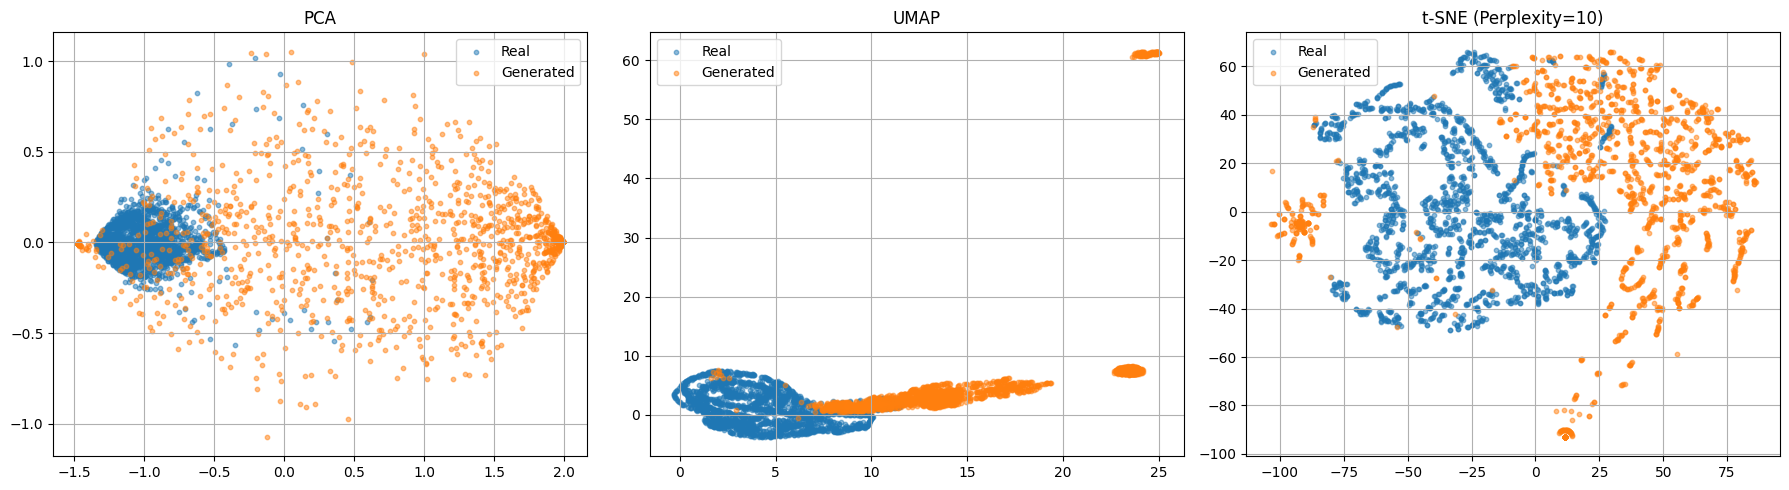

In [29]:
vizual_comparison(samples, real_data_test, os.path.join(logging_dir, "viz/", "pca_umap_tsne_all_batches.png"), use_all_data=True);

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


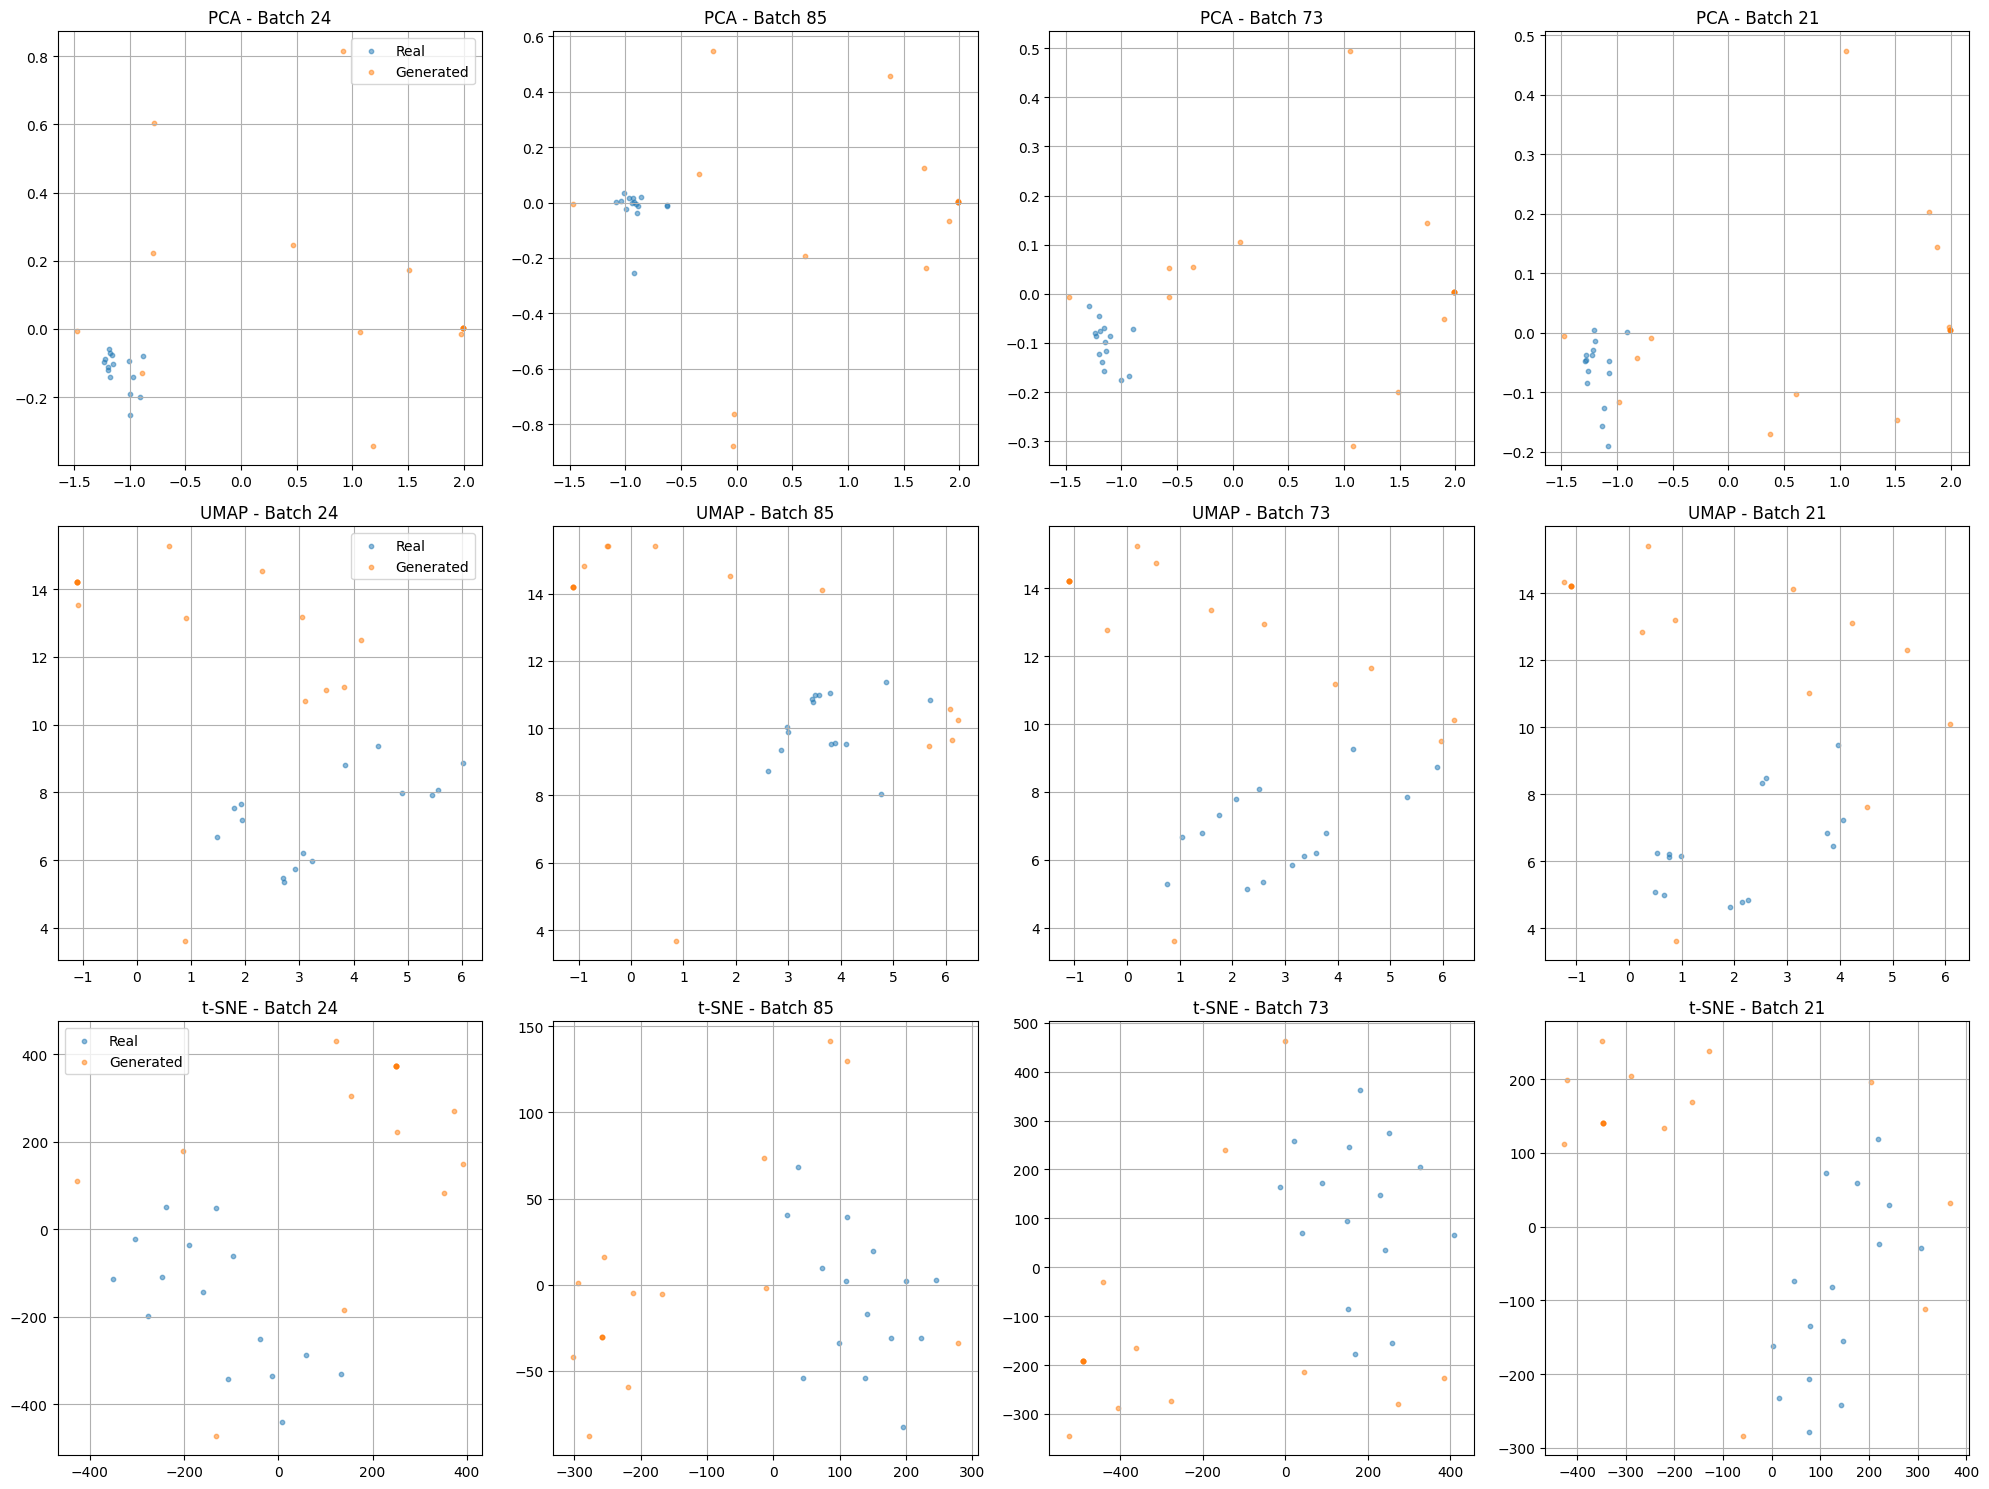

In [30]:
vizual_comparison(samples, real_data_test, os.path.join(logging_dir, "viz/", "pca_umap_tsne_per_batch.png"));

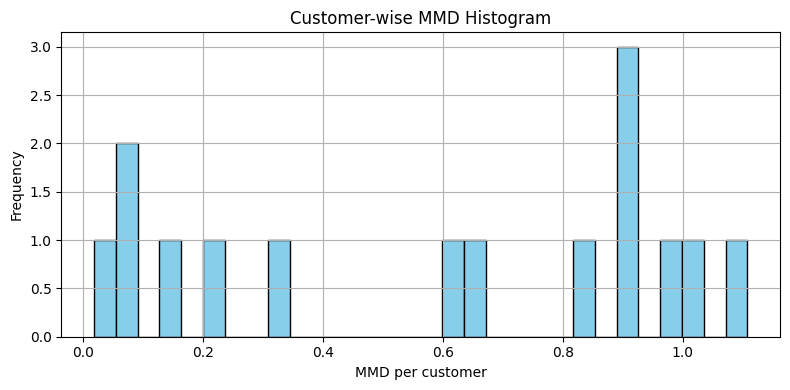

In [31]:
mmd_histogram_per_customer(samples, real_data_test, fpath=os.path.join(logging_dir, "mmd/", "mmd.png"))

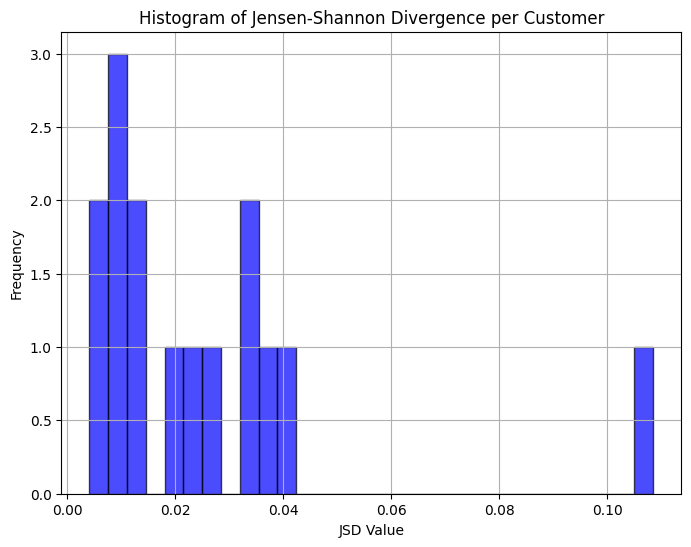

In [32]:
plot_jsd_per_customer(samples, real_data_test, os.path.join(logging_dir, "jsd/", "jsd.png"))

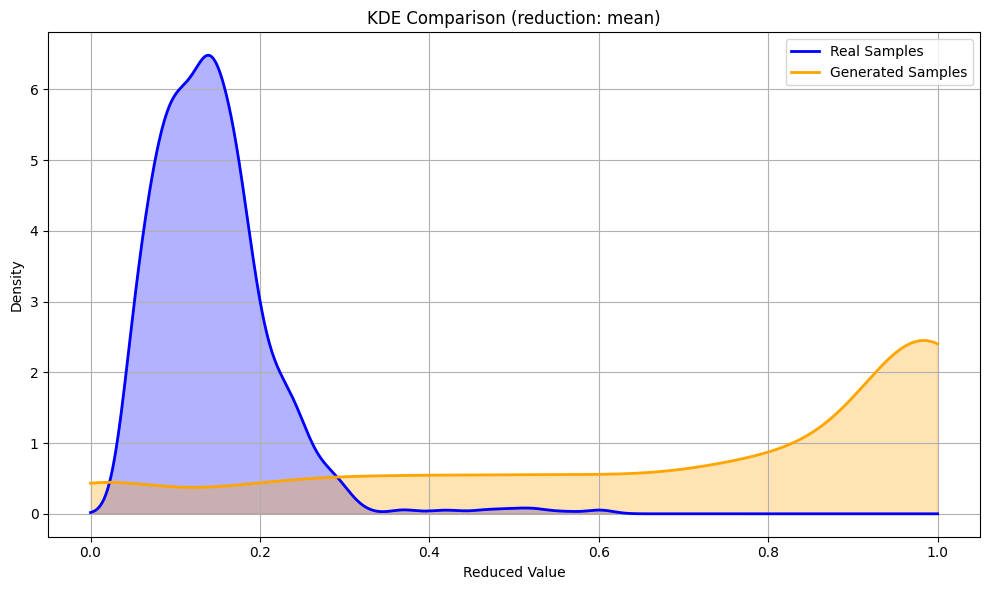

In [33]:
plot_kde_samples(samples, real_data_test, fpath=os.path.join(logging_dir, "kde/", f"kde.png"))

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\RNN.cpp:1410.)
  result = _VF.lstm(
sampling loop time step: 100%|██████████| 1000/1000 [00:13<00:00, 75.92it/s]


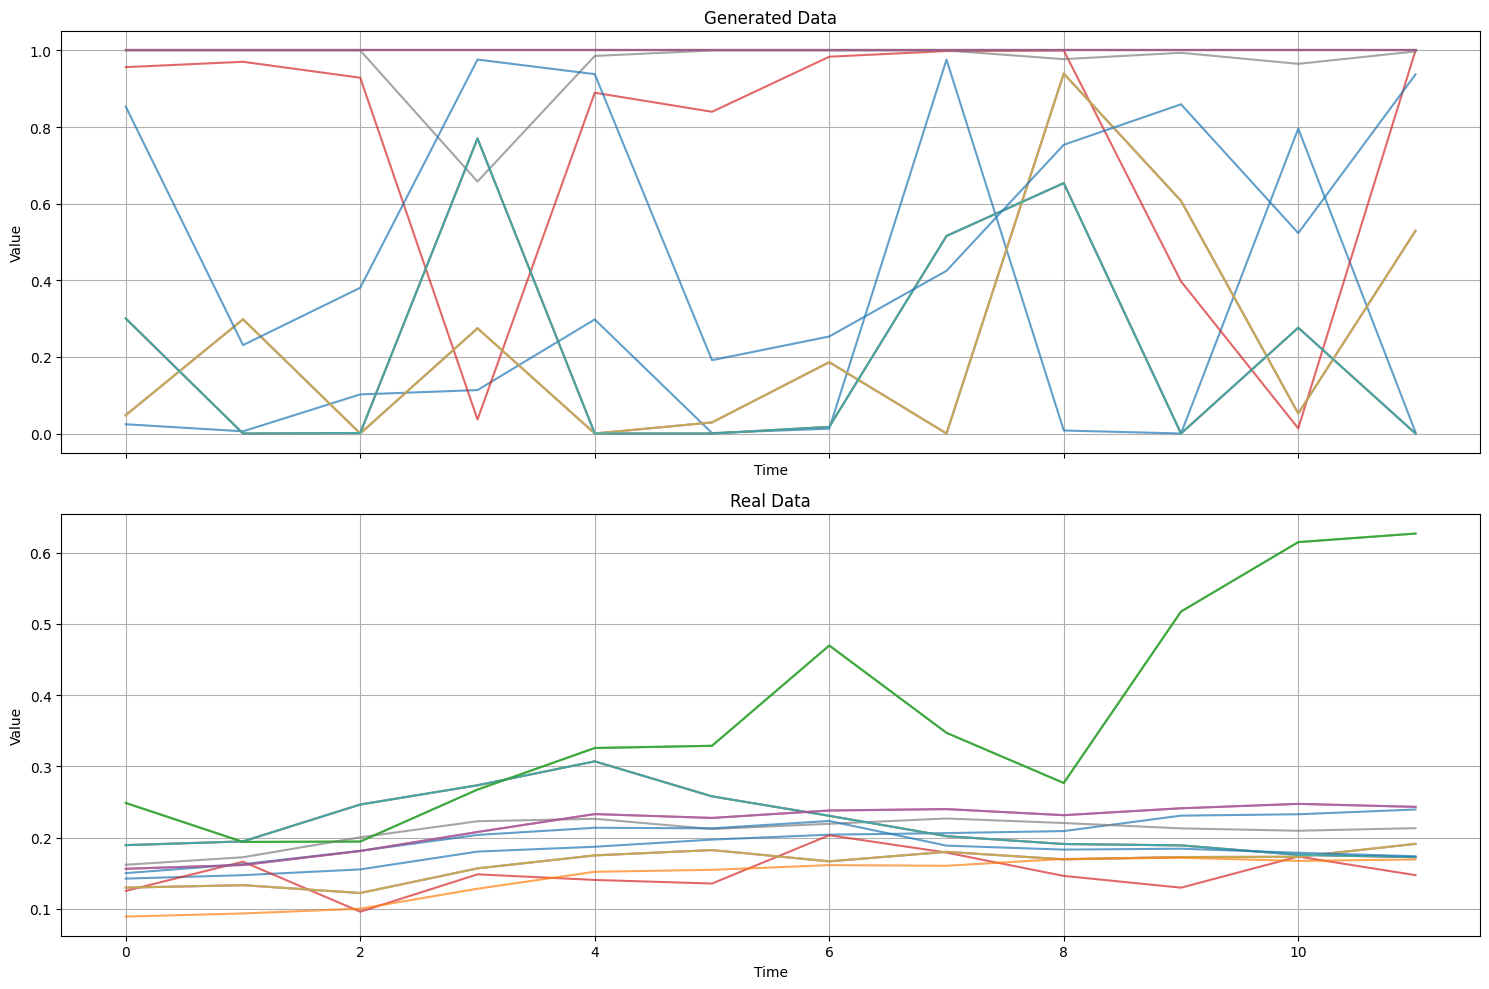

In [34]:
batch_idx = np.random.randint(0, 256) 
customer_indices = np.random.randint(0, 15, size=15)
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

with torch.no_grad():
    sample = ddpm.sample(batch_size, real_cond_data_test.to(device)) 
    sample = sample.cpu().numpy() 

for i in customer_indices:
    axs[0].plot(sample[0, i], alpha=0.7, label=f'Customer {i}')
    axs[1].plot(real_data_test[0, i], alpha=0.7, label=f'Customer {i}')

axs[0].set_title("Generated Data")
axs[1].set_title("Real Data")

for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(logging_dir, "viz/", "samples.png"))
plt.show()